In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras import regularizers
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [34]:
base_skin_dir = os.path.join('./data')

In [35]:
# Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [36]:
# Read in the csv of metadata

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df.tail()


,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [37]:
# Create some new columns (path to image, human-readable name) and review them

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
8950,HAM_0006835,ISIC_0026577,nv,histo,75.0,male,chest,./data\HAM10000_images_part_1\ISIC_0026577.jpg,Melanocytic nevi,4
2360,HAM_0000940,ISIC_0032692,vasc,histo,35.0,female,lower extremity,./data\HAM10000_images_part_2\ISIC_0032692.jpg,Vascular lesions,6
724,HAM_0003392,ISIC_0030240,bkl,histo,70.0,male,scalp,./data\HAM10000_images_part_2\ISIC_0030240.jpg,Benign keratosis-like lesions,2
3700,HAM_0005506,ISIC_0032484,nv,follow_up,60.0,male,trunk,./data\HAM10000_images_part_2\ISIC_0032484.jpg,Melanocytic nevi,4
3273,HAM_0000154,ISIC_0025930,nv,follow_up,35.0,female,trunk,./data\HAM10000_images_part_1\ISIC_0025930.jpg,Melanocytic nevi,4


In [38]:
# Get general statistics for the dataset

tile_df.describe(exclude=[np.number])


,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0001863,ISIC_0027858,nv,histo,male,back,./data\HAM10000_images_part_1\ISIC_0027600.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


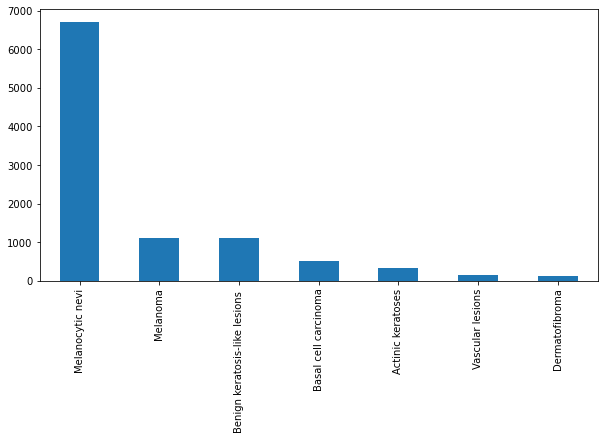

In [39]:
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


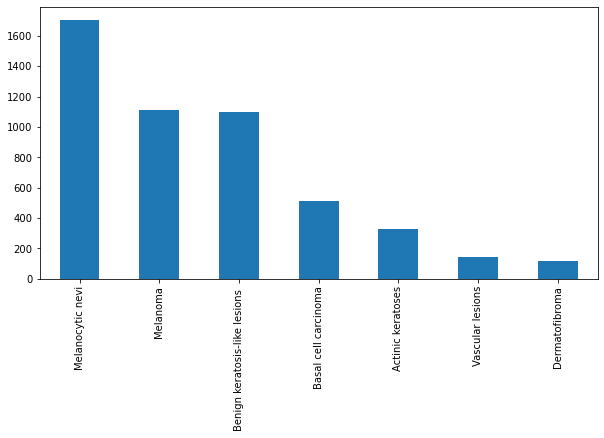

In [40]:
# Too many melanocytic nevi - let's balance it a bit!

tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)



In [41]:
input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

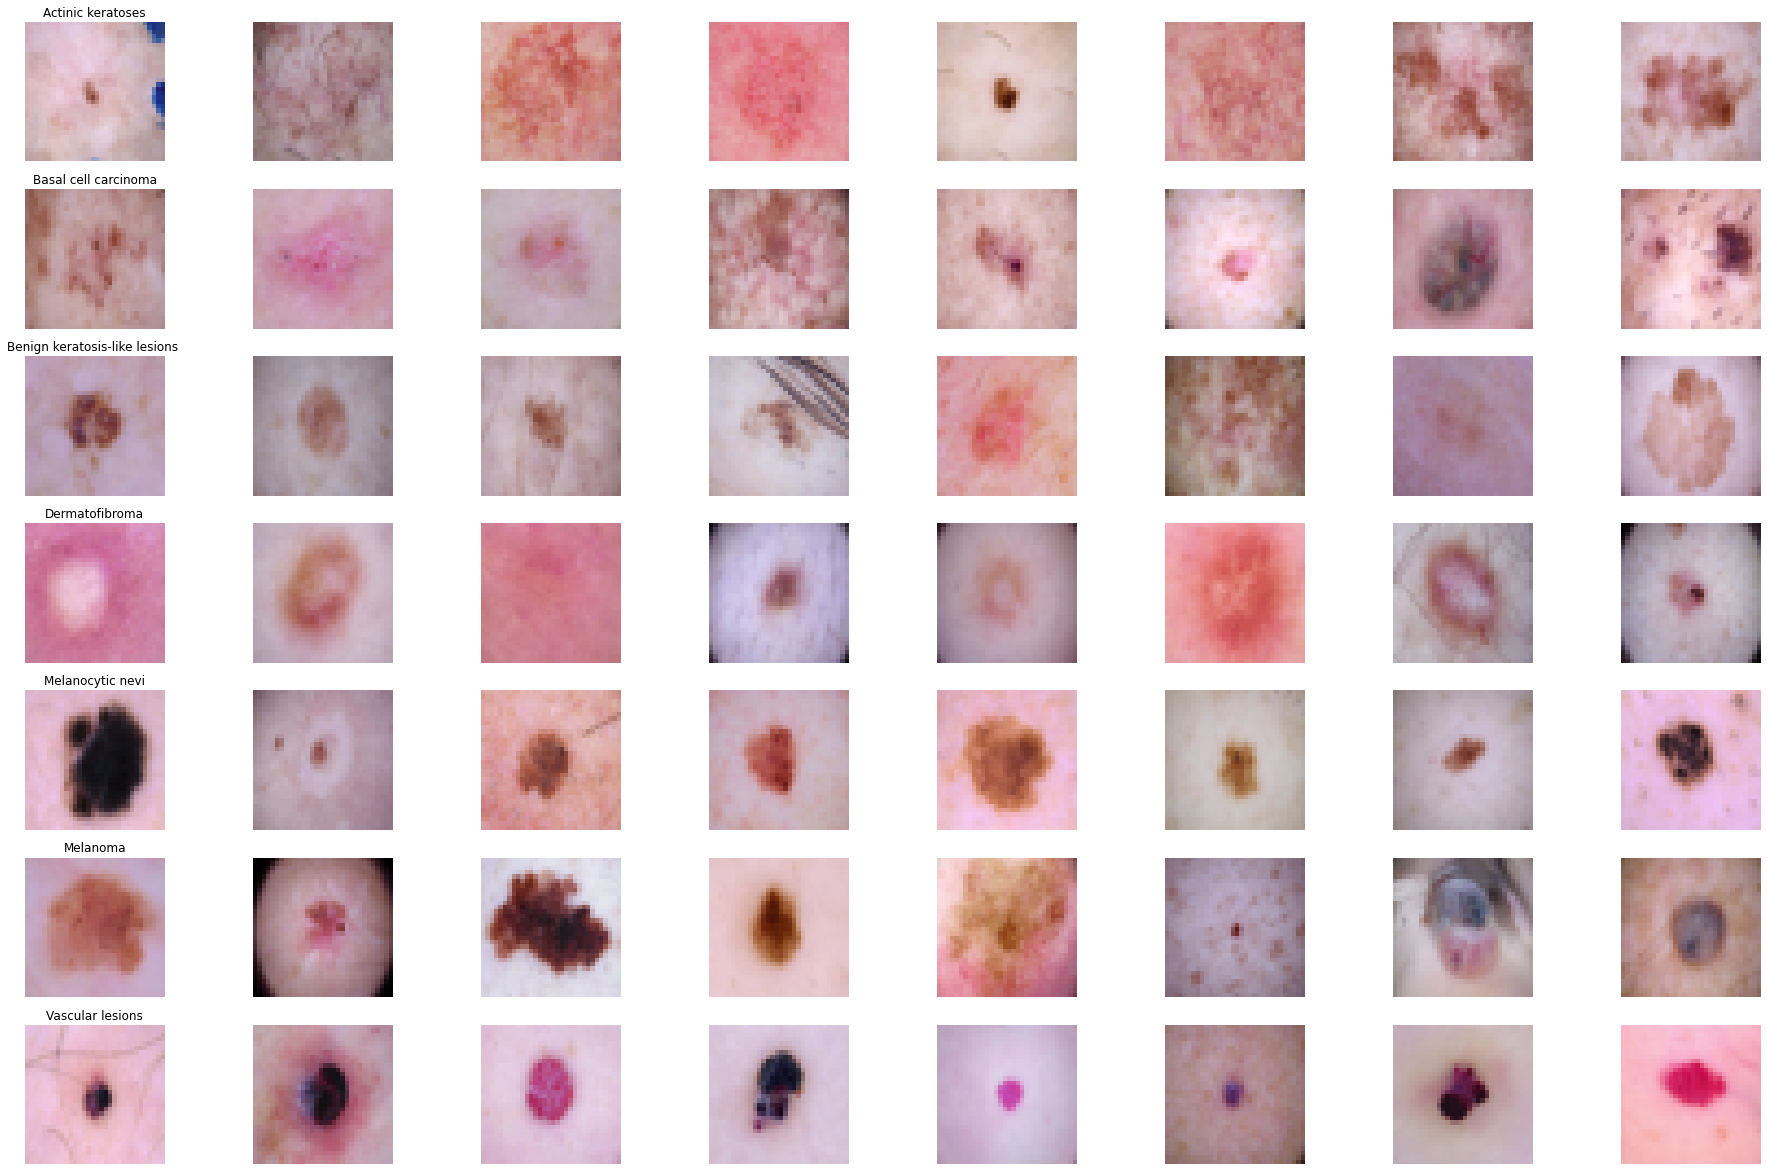

In [42]:
n_samples = 8
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [43]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(32, 32, 3)    5015
Name: image, dtype: int64

In [44]:
# Export to csv 
# tile_df.to_csv('processed_data.csv')

In [45]:
y = tile_df.cell_type_idx
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

In [46]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [47]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [48]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [49]:
input_shape = (32, 32, 3)
num_classes = 7
batch_size = 32 
epochs = 25

In [50]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [51]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0

In [52]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/25
118/118 [==============================] - 12s 101ms/step - loss: 2.5070 - accuracy: 0.3744 - val_loss: 1.8126 - val_accuracy: 0.4362
Epoch 2/25
118/118 [==============================] - 11s 92ms/step - loss: 1.6458 - accuracy: 0.4169 - val_loss: 1.5331 - val_accuracy: 0.4370
Epoch 3/25
118/118 [==============================] - 11s 96ms/step - loss: 1.4967 - accuracy: 0.4422 - val_loss: 1.4935 - val_accuracy: 0.4410
Epoch 4/25
118/118 [==============================] - 12s 98ms/step - loss: 1.4416 - accuracy: 0.4685 - val_loss: 1.4067 - val_accuracy: 0.4809
Epoch 5/25
118/118 [==============================] - 11s 94ms/step - loss: 1.4293 - accuracy: 0.4751 - val_loss: 1.4297 - val_accuracy: 0.4809
Epoch 6/25
118/118 [==============================] - 11s 97ms/step - loss: 1.3820 - accuracy: 0.5007 - val_loss: 1.3708 - val_accuracy: 0.5040
Epoch 7/25
118/118 [==============================] - 11s 95ms/step - loss: 1.3611 - accuracy: 0.5145 - val_loss: 1.3512 - val_accuracy

In [180]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3142941781398403
Test accuracy: 0.5996810208287155


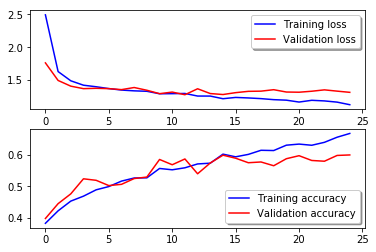

In [181]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



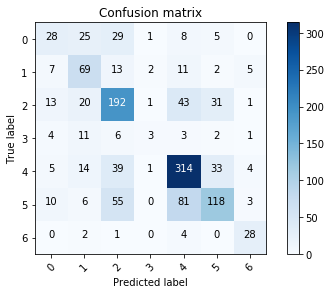

In [183]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

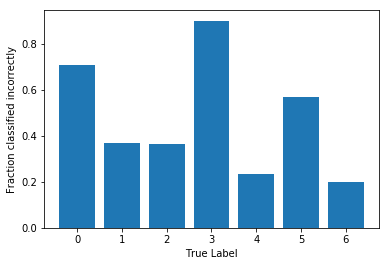

In [184]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')